# Proximity Metrics and Node Prediction

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

###  Question 1  Implement from scratch any 3 proximity metrics (choosing at least 1 from each of local and global metrics) (7)



In [2]:
### Common Neighbour Score (Local Measure)
def common_neighbour_score(G, x, y):
    x_neighbours = set(G.neighbors(x))
    y_neighbours = set(G.neighbors(y))
    
    #the score is the number of common neighbours (intersection)
    score =  len(((x_neighbours) & (y_neighbours))) 
    return score


### Jaccard Coefficient Score (Local Measure)
def jaccard_coefficient_score(G, x, y):
    x_neighbours = set(G.neighbors(x))
    y_neighbours = set(G.neighbors(y))
    
    #the score is the number of common neighbours (intersection)
    intersection = (x_neighbours) & (y_neighbours)
    union  = (x_neighbours) | (y_neighbours)
    score =  len(intersection) / len(union)
    
    return score


### Katz Index score (Global measure) 
def katz_index_score(G, x, y, beta):

    #get paths with length 2 or more
    paths = [path for path in list(nx.all_simple_paths(G, x, y)) if len(path) > 2]
    
    score = 0
    for path in paths:
        l = len(path)
        score += beta**l * l
    
    return score
    


### Question 2. Which metric performs the best for the given graph (compare performance on accuracy and f1-score). (You will need to implement the link prediction and measurement framework from scratch (8)

Anwswer: Link Prediction and Test framework implementation is below.  Based on the results in the Testing secion, all metric performed poorly.  For a random graph generated, the local metrics ('common neighbour' and 'jaccardian coefficient') happen to predict 1/10 edges accurately.  

In [3]:

# # prodict k potential edges based on the score
def link_prediction(G, metric_type, k):

    #keep track of scores
    scores = {}

    #compute score between each pair of nodes in the graph
    for edge in G.edges:
        if metric_type == 'common_neighbour':
            score = common_neighbour_score(G, edge[0], edge[1])
        elif metric_type == 'jaccard_coefficient':
            score = jaccard_coefficient_score(G, edge[0], edge[1])
        elif metric_type == 'katz_index':
            score = katz_index_score(G, edge[0], edge[1], 0.5)

        key = '{0}|{1}'.format(edge[0], edge[1])
        scores[key] = score
       

    #get the top k scores
    sorted_scores = sorted(scores.items(), reverse=True, key = lambda kv:  kv[1])
    
    edge_predicted = []

    #got through the similar nodes
    for score in sorted_scores:
        node1, node2 = score[0].split('|')

        if node1.isdigit():
            node1 = int(node1)
            node2 = int(node2)

        #get neighbours of node1
        node1_neighbours = list(G.neighbors(node1))

        #get neighbours of node2
        node2_neighbours = list(G.neighbors(node2))

        #node1 links based on similarity to node2
        node1_edges = ([(node1, node) for node in node2_neighbours if (node not in node1_neighbours) and (node1 != node)])

        #node2 links based on similarity to node1
        node2_edges = ([(node2, node) for node in node1_neighbours if (node not in node2_neighbours) and (node2 != node)])

        #add the node1 and node2 edges based 
        
        edge_predicted += node1_edges
        edge_predicted += node2_edges
    
    return (edge_predicted[0:k])

    

def test_framework(G, metric_type, seed=None):
    
    edges = list(G.edges)

    #use 80/20 ratio for training/testing
    train, test = train_test_split(range(0, len(edges)), test_size=0.2, random_state=seed)
    edges_train = [edges[i] for i in train]
    edges_test = [edges[i] for i in test]

    G_train = nx.Graph()
    for e in edges_train:
        G_train.add_edge(e[0], e[1])
    
    #get the 10 predicted edges from G_train using common neighbour
    edges_predicted = (link_prediction(G_train, metric_type, 10))
    
    #test accuracy (how many predicted edges are in the test graph)
    intersection = (set(edges_predicted)) & (set(edges_test))
    
    #accuracy 
    accuracy = len(intersection) / len(edges_predicted)
    
    return {'accuracy': accuracy, 'edges_predicted':edges_predicted}
    

# Testing

## Toy Graph

{('A', 'D'): Text(-0.014515484963562766, 0.10170230773487818, "{'weight': 7}"),
 ('A', 'B'): Text(-0.2554565750381678, -0.12504378335890215, "{'weight': 2}"),
 ('A', 'E'): Text(-0.4823176761619382, -0.04564254655097304, "{'weight': 4}"),
 ('D', 'B'): Text(-0.017682323838062022, -0.140625504726232, "{'weight': 3}"),
 ('D', 'C'): Text(0.6116293831182714, 0.22932834446097944, "{'weight': 2}"),
 ('B', 'E'): Text(-0.48548451503643747, -0.28797035901208323, "{'weight': 5}")}

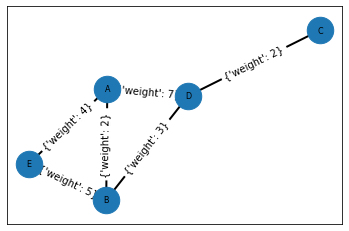

In [11]:
#Toy Graph
edge_list = [('A','D',7), ('A','B',2), ('A','E',4), ('B','E',5), ('B','D',3), ('D','C',2)]
G = nx.Graph()

for x, y, z in edge_list: 
    G.add_edge(x, y, weight=z)  # Ignore the weights

pos = nx.spring_layout(G)  # positions for all nodes

nx.draw_networkx_nodes(G, pos, node_size=700, with_labels=True)
nx.draw_networkx_edges(G, pos, width=2)
nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')
nx.draw_networkx_edge_labels(G, pos)

## Testing Proximity Metrics on Toy Graph

In [5]:
print(common_neighbour_score(G, 'A', 'C'))
print(jaccard_coefficient_score(G, 'A', 'C'))
print(katz_index_score(G, 'A', 'C', 0.5))

1
0.3333333333333333
0.78125


## Rading CA-AstroPh.txt (graph was too large to run metrics)

In [6]:
df = pd.read_csv('CA-AstroPh.txt', sep='\t', skiprows=4, header=None, names=['source', 'target'])

G = nx.from_pandas_edgelist(df, source='source', target='target')

## Random graph (Ground Truth) for Testing Link Prediction

50


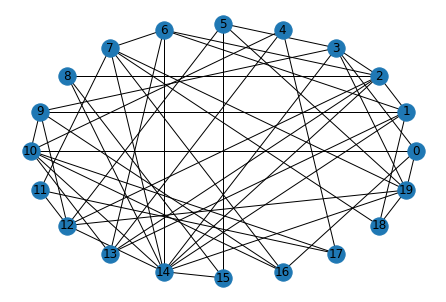

In [7]:
G = nx.fast_gnp_random_graph(20, 0.25, 1913)
print(len(G.edges))

nx.draw_shell(G, with_labels=True)


## Run through Testing Framework Using 80% of edges for Training and 20% for Testing

In [8]:
test_framework(G, 'common_neighbour', 1913)

{'accuracy': 0.1,
 'edges_predicted': [(14, 18),
  (14, 5),
  (19, 8),
  (19, 10),
  (19, 15),
  (19, 6),
  (1, 7),
  (1, 14),
  (6, 9),
  (6, 18)]}

In [9]:
test_framework(G, 'jaccard_coefficient', 1913)

{'accuracy': 0.1,
 'edges_predicted': [(14, 18),
  (14, 5),
  (19, 8),
  (19, 10),
  (19, 15),
  (19, 6),
  (1, 7),
  (1, 14),
  (6, 9),
  (6, 18)]}

In [10]:
test_framework(G, 'katz_index', 1913)

{'accuracy': 0.0,
 'edges_predicted': [(9, 14),
  (9, 2),
  (9, 19),
  (9, 5),
  (3, 1),
  (3, 10),
  (3, 16),
  (7, 10),
  (7, 0),
  (7, 9)]}